In [36]:
import json

import matplotlib.pyplot as plt
import numpy as np

In [1]:
import os
os.chdir("..")

In [2]:
import sim.sim

In [5]:
times, breaths, flow, volume, pressure = sim.sim.make()

In [7]:
times.shape, breaths.shape, flow.shape, volume.shape, pressure.shape

((12000,), (12,), (12000,), (12000,), (12000,))

In [12]:
breaths

array([ 12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120., 132.,
       144.])

In [27]:
def tojson(times, flow, pressure):
    return "\n".join(json.dumps({"v": 1, "t": float(t), "P": float(P), "F": float(F)})
                     for t, P, F in zip(times, flow, pressure))

# print(tojson(times, flow, pressure))

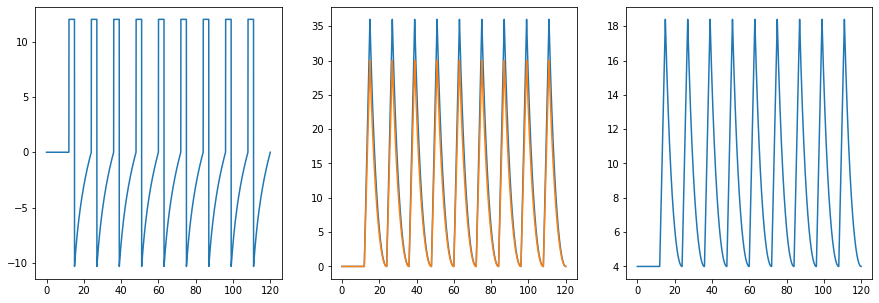

In [61]:
def plot3(times, flow, volume, pressure):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.plot(times, flow)

    # Yes, the volume really is just an integral of the flow.
    ax2.plot(times, volume)
    ax2.plot(times, np.cumsum(flow) / (times[-1] - times[0]))

    ax3.plot(times, pressure)

plot3(times, flow, volume, pressure)

In [73]:
def plot2(times, flow, pressure):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(times, flow)
    ax2.plot(times, pressure)

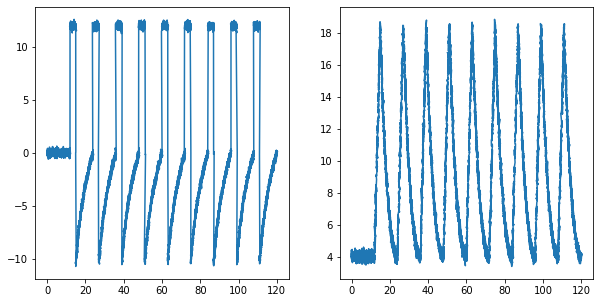

In [199]:
def fuzz(times, flow, pressure):
    mask = np.random.randint(0, 5, len(times)) != 0
    length = np.count_nonzero(mask)
    times = times[mask] + np.random.normal(0, 0.2, length)
    flow = flow[mask] + np.random.normal(0, 0.2, length)
    pressure = pressure[mask] + np.random.normal(0, 0.2, length)
    return times, flow, pressure

plot2(*fuzz(times, flow, pressure))

In [200]:
data = list(zip(*fuzz(times, flow, pressure)))

My favorite [one-pass local regression filter](https://en.wikipedia.org/wiki/Local_regression)! It's $\mathcal{O}(N \cdot W)$ where $N$ is the size of the dataset and $W$ the size of the window, but it also requires the data to be pre-sorted, so $\mathcal{O}(N \log N + N \cdot W)$ if we have to sort.

In [201]:
data.sort(key=lambda x: x[0])

In [205]:
sig = 0.2
smoothed_start = 0.0
smoothed_stop = 120.0
smoothed_steps = int(100*(smoothed_stop - smoothed_start))

smoothed_times = np.linspace(smoothed_start, smoothed_stop, smoothed_steps)
smoothed_flow = np.zeros(len(smoothed_times))
smoothed_dflow = np.zeros(len(smoothed_times))
smoothed_pressure = np.zeros(len(smoothed_times))
smoothed_dpressure = np.zeros(len(smoothed_times))

def linear_fit(w, x, y):
    sumw   = np.sum(w)
    sumwx  = np.sum(w * x)
    sumwy  = np.sum(w * y)
    sumwxx = np.sum(w * x * x)
    sumwxy = np.sum(w * x * y)
    delta     = (sumw*sumwxx) - (sumwx*sumwx)
    intercept = ((sumwxx*sumwy) - (sumwx*sumwxy)) / delta
    slope     = ((sumw*sumwxy) - (sumwx*sumwy)) / delta
    return intercept, slope

window_times = []
window_flow = []
window_pressure = []
data_i = 0
for i, t in enumerate(smoothed_times):
    # window contains all data ±3*sig of t
    while data_i < len(data) and data[data_i][0] < t + 3*sig:
        window_times.append(data[data_i][0])
        window_flow.append(data[data_i][1])
        window_pressure.append(data[data_i][2])
        data_i += 1
    while len(window_times) > 0 and window_times[0] < t - 3*sig:
        window_times.pop(0)
        window_flow.pop(0)
        window_pressure.pop(0)

    win_times    = np.array(window_times) - t
    win_flow     = np.array(window_flow)
    win_pressure = np.array(window_pressure)

    # weighting kernel: Gaussian
    win_weights = np.exp(-0.5 * win_times**2 / sig**2)

    smoothed_flow[i],     smoothed_dflow[i]     = linear_fit(win_weights, win_times, win_flow)
    smoothed_pressure[i], smoothed_dpressure[i] = linear_fit(win_weights, win_times, win_pressure)

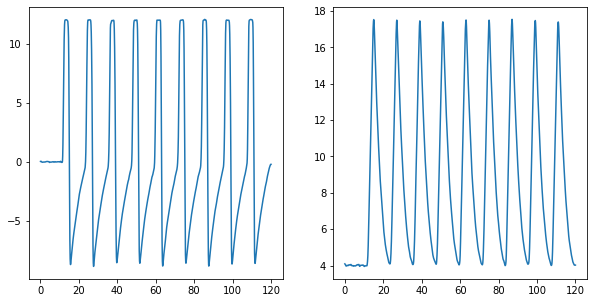

In [206]:
plot2(smoothed_times, smoothed_flow, smoothed_pressure)

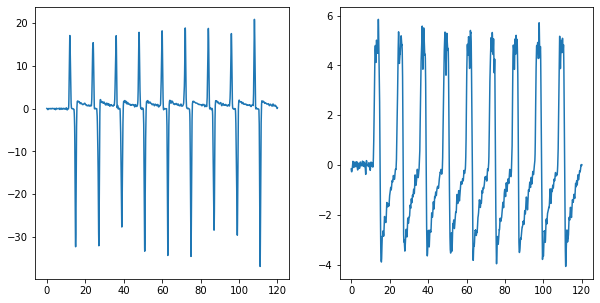

In [207]:
plot2(smoothed_times, smoothed_dflow, smoothed_dpressure)

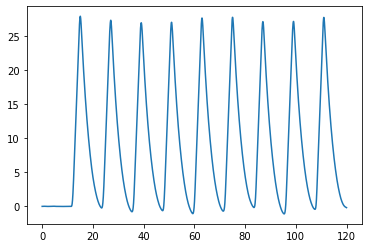

In [210]:
smoothed_volume = np.cumsum(smoothed_flow) / (smoothed_stop - smoothed_start)

plt.plot(smoothed_times, smoothed_volume)

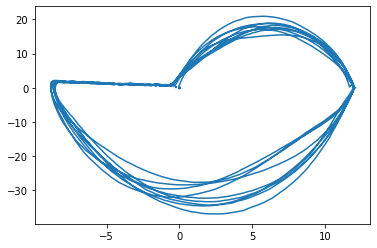

In [208]:
plt.plot(smoothed_flow, smoothed_dflow)

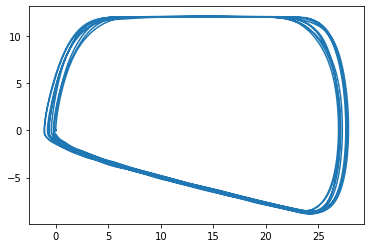

In [211]:
plt.plot(smoothed_volume, smoothed_flow)

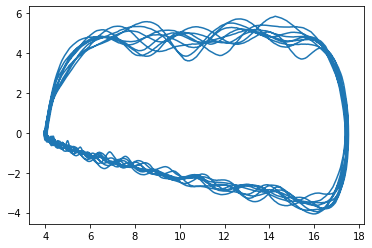

In [209]:
plt.plot(smoothed_pressure, smoothed_dpressure)

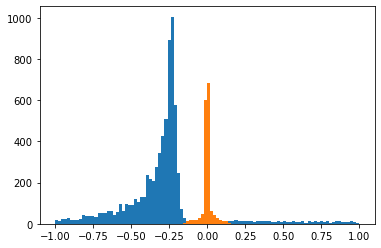

In [268]:
inhale = np.logical_and(abs(smoothed_dflow / smoothed_flow) < 0.15, smoothed_flow > 1)

plt.hist(smoothed_dflow[~inhale] / smoothed_flow[~inhale], bins=100, range=(-1, 1));
plt.hist(smoothed_dflow[inhale] / smoothed_flow[inhale], bins=100, range=(-1, 1));

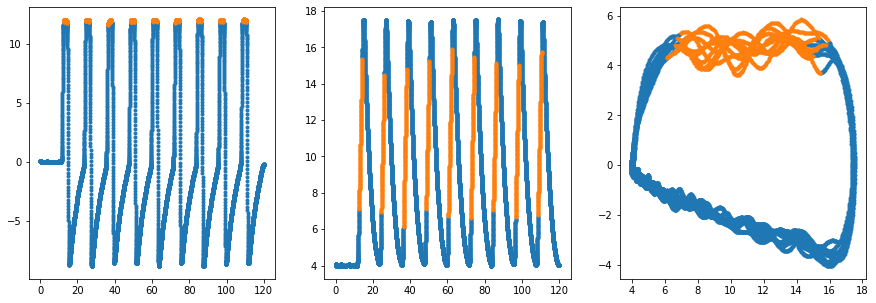

In [271]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(smoothed_times[~inhale], smoothed_flow[~inhale], ".")
ax1.plot(smoothed_times[inhale], smoothed_flow[inhale], ".")
ax2.plot(smoothed_times[~inhale], smoothed_pressure[~inhale], ".")
ax2.plot(smoothed_times[inhale], smoothed_pressure[inhale], ".")
ax3.plot(smoothed_pressure[~inhale], smoothed_dpressure[~inhale], ".")
ax3.plot(smoothed_pressure[inhale], smoothed_dpressure[inhale], ".")

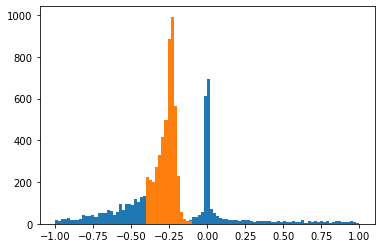

In [272]:
exhale = np.logical_and(abs(-0.25 - (smoothed_dflow / smoothed_flow)) < 0.15, smoothed_flow < -1)

plt.hist(smoothed_dflow[~exhale] / smoothed_flow[~exhale], bins=100, range=(-1, 1));
plt.hist(smoothed_dflow[exhale] / smoothed_flow[exhale], bins=100, range=(-1, 1));

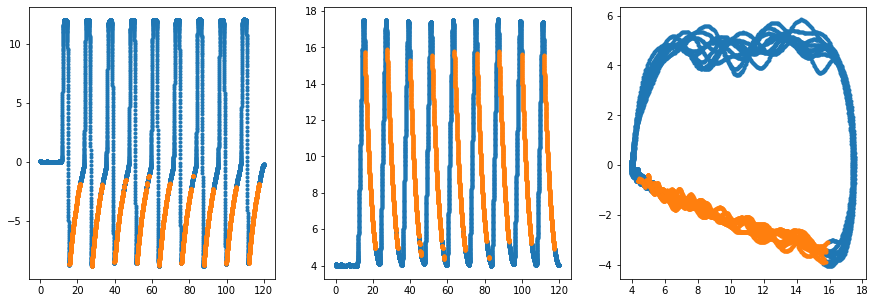

In [273]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(smoothed_times[~exhale], smoothed_flow[~exhale], ".")
ax1.plot(smoothed_times[exhale], smoothed_flow[exhale], ".")
ax2.plot(smoothed_times[~exhale], smoothed_pressure[~exhale], ".")
ax2.plot(smoothed_times[exhale], smoothed_pressure[exhale], ".")
ax3.plot(smoothed_pressure[~exhale], smoothed_dpressure[~exhale], ".")
ax3.plot(smoothed_pressure[exhale], smoothed_dpressure[exhale], ".")

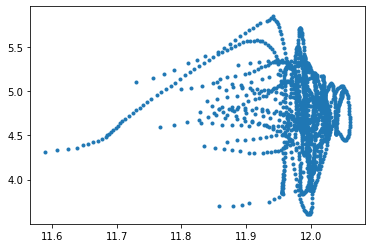

In [274]:
# Inhale complince is roughly a spot in the (Δv/Δt, ΔP/Δt) plane
plt.plot(smoothed_flow[inhale], smoothed_dpressure[inhale], ".")

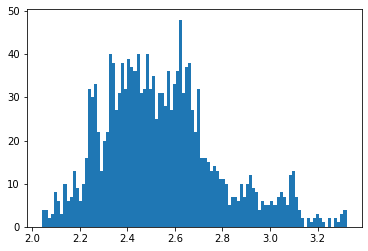

In [276]:
plt.hist(smoothed_flow[inhale]/smoothed_dpressure[inhale], bins=100);

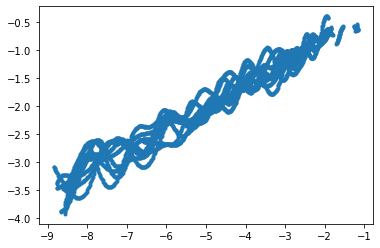

In [275]:
# Exhale compliance is on a broader line in the (Δv/Δt, ΔP/Δt) plane, but still with constant slope
plt.plot(smoothed_flow[exhale], smoothed_dpressure[exhale], ".")

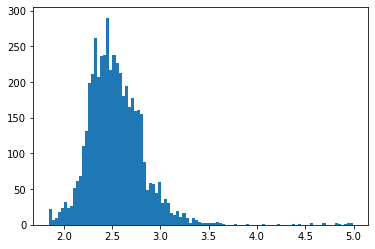

In [277]:
plt.hist(smoothed_flow[exhale]/smoothed_dpressure[exhale], bins=100);